In [2]:
cd ../../task_01/pipelines

/Users/pldelacour/Documents/PL_Ecole/data_sc_lab/data_sc_lab/task_01/pipelines


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipynb.fs.full.tool_functions import *
from yellowbrick.regressor import AlphaSelection
from  sklearn.metrics import mean_squared_error

/Users/pldelacour/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [27]:
df_beha = pd.read_csv('../../../data/Behavioral/AllData.csv')#, nrows=1000)

#df_psd_cluster = pd.read_csv("../../../data/EEG/RestingEEG_PSD_Cluster.csv") #, nrows=1000)
#df_psd_channel = pd.read_csv("../../../data/EEG/RestingEEG_PSD_Channel.csv") #, nrows=5)
df_spectro_cluster = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Cluster.csv") #, nrows=1000)
df_spectro_channel = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Channel.csv") #, nrows=5)

#df_microstate = pd.read_csv("../../../data/EEG/RestingEEG_Microstates.csv") #, nrows=5)

In [28]:
#df_beha.pivot_table(index=['DX_01'], aggfunc='size')

In [70]:
y_labels = df_beha[["Patient_ID", "Age", "DX_01" , "DX_02" ,"DX_01_Cat"]]
y1 = y_labels["DX_01"]
y2 = y_labels["DX_02"]
type1 = (y1.str.contains("ADHD-Combined")==True) & ( y2.str.contains("Autism") ==False )
type2 = (y1.str.contains("Autism")==True) & ( y2.str.contains("ADHD-Combined") ==False )
type3 = (y1.str.contains("ADHD-Combined")==True) & ( y2.str.contains("Autism") ==True )
#Healthy
type4 = (y1.str.contains("Autism")==True) & ( y2.str.contains("ADHD-Combined") ==True )
type_healthy = y_labels["DX_01_Cat"].str.contains("No Diagnosis Given") == True

In [71]:
print("type 1 = " , np.sum(type1))
print("type 2 = " , np.sum(type2))
print("type 3 = " , np.sum(type3))
print("type 4 = " , np.sum(type4))
print("type Healthy = " , np.sum(type_healthy))

type 1 =  164
type 2 =  78
type 3 =  36
type 4 =  54
type Healthy =  513


In [72]:
y = 100*np.ones(len(type1))
y[type1] = 1
y[type2] = 2
y[type3] = 3
y[type4] = 4
y[type_healthy] = 0

In [73]:
len(y)

2096

In [74]:
ind = type1 | type2 | type3 | type4 | type_healthy
df_dis = df_beha[["Patient_ID", "Age"]]
df_dis['disease'] = y
df_spectro_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)

# Aggregate with label
df_dis_spectro = pd.merge(df_dis, df_spectro_cluster, on='Patient_ID')
#Replace NAN
df_dis_spectro = fill_with_median(df_dis_spectro)


df_dis_spectro = df_dis_spectro.loc[df_dis_spectro['disease']!=100 , : ]

X = df_dis_spectro.drop(['Patient_ID', 'disease'], axis=1)
y =  df_dis_spectro[['disease']]

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)
X = np.array(X)
y = np.array(y)

/Users/pldelacour/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
print(np.sum(df_dis_spectro['disease']==0))
print(np.sum(df_dis_spectro['disease']==1))
print(np.sum(df_dis_spectro['disease']==2))
print(np.sum(df_dis_spectro['disease']==3))
print(np.sum(df_dis_spectro['disease']==4))

174
124
47
27
42


## PCA for group of disease

In [68]:
cd ../../task_02/plot_dis

/Users/pldelacour/Documents/PL_Ecole/data_sc_lab/data_sc_lab/task_02/plot_dis


In [69]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

In [77]:
ds_map = {0:"Healthy" , 1:"ADHD" , 2:"Autism", 3:"1-ADHD, 2-Autism" , 4:"1-Autism, 2-ADHD" }

In [78]:
target_names = []
for i in ds_map.values() :
    target_names.append(i)
target_names

['Healthy', 'ADHD', 'Autism', '1-ADHD, 2-Autism', '1-Autism, 2-ADHD']

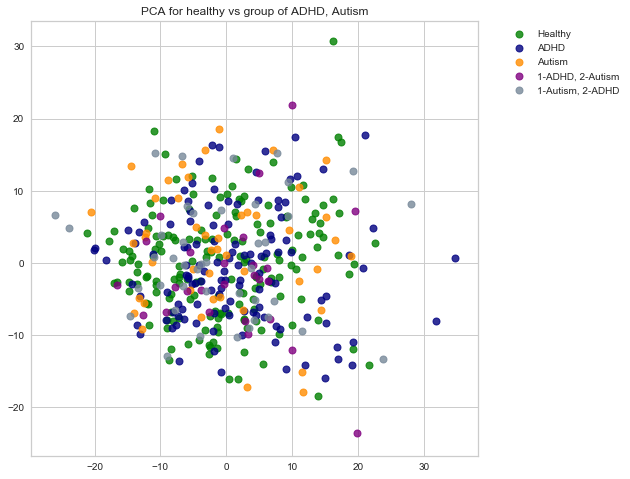

In [81]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

#pca = FastICA(n_components=2)
#X_r = pca.fit(X).transform(X)

target_names = []
for i in ds_map.values() :
    target_names.append(i)

keys = []
for i in ds_map.keys() :
    keys.append(i)

#plt.figure()
plt.figure(figsize=(8, 8))
colors = ['green' , 'navy', 'darkorange'  , 'purple', 'lightslategrey']
#, 'lightslategrey'  , 'hotpink' , 'crimson']
lw = 1

for color, i, target_name in zip(colors, keys, target_names):
    plt.scatter(X_r[(y==i).flatten(), 0], X_r[(y==i).flatten(), 1], color=color, alpha=.8, lw=lw,
                label=target_name)

plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA for healthy vs group of ADHD, Autism')


plt.show
filename = 'pca_group_ADHD_Autism.png'
#filename = 'ica_all_diseases.png'
plt.savefig(filename, bbox_inches = 'tight')

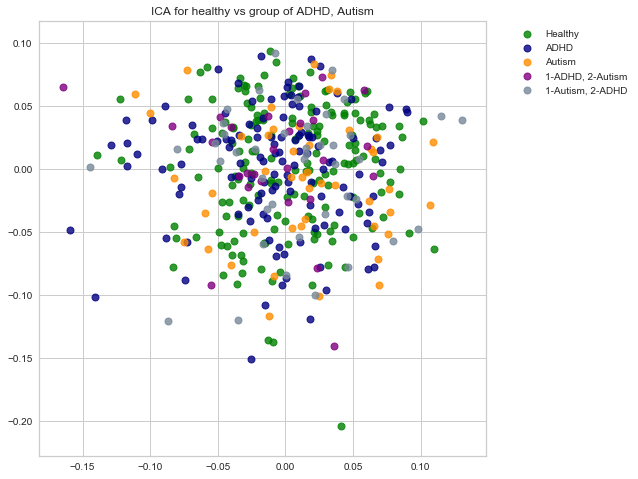

In [84]:
pca = FastICA(n_components=2)
X_r = pca.fit(X).transform(X)

target_names = []
for i in ds_map.values() :
    target_names.append(i)

keys = []
for i in ds_map.keys() :
    keys.append(i)

#plt.figure()
plt.figure(figsize=(8, 8))
colors = ['green' , 'navy', 'darkorange'  , 'purple', 'lightslategrey']
#, 'lightslategrey'  , 'hotpink' , 'crimson']
lw = 1

for color, i, target_name in zip(colors, keys, target_names):
    plt.scatter(X_r[(y==i).flatten(), 0], X_r[(y==i).flatten(), 1], color=color, alpha=.8, lw=lw,
                label=target_name)

plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('ICA for healthy vs group of ADHD, Autism')


plt.show
filename = 'ica_group_ADHD_Autism.png'
#filename = 'ica_all_diseases.png'
plt.savefig(filename, bbox_inches = 'tight')